In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
from collections import defaultdict
import time


In [4]:

class BaseEmbeddingModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = nn.Dropout(0.2)
        self.layer1 = nn.Linear(embedding_dim, embedding_dim * 2)
        self.layer2 = nn.Linear(embedding_dim * 2, embedding_dim)
        self.fc = nn.Linear(embedding_dim, vocab_size)
        
    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)
        pooled = torch.mean(embedded, dim=1)
        x = F.relu(self.layer1(pooled))
        x = self.dropout(x)
        x = F.relu(self.layer2(x))
        x = self.dropout(x)
        return self.fc(x)
    
    def get_embeddings(self, x):
        return self.embedding(x)
    
    def get_similarity(self, x1, x2):
        embedded1 = self.embedding(x1)
        embedded2 = self.embedding(x2)
        return F.cosine_similarity(embedded1.mean(1), embedded2.mean(1))

class CrossAttentionModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = nn.Dropout(0.2)
        self.attention = nn.MultiheadAttention(embedding_dim, num_heads=4, batch_first=True, dropout=0.1)
        self.layer1 = nn.Linear(embedding_dim, embedding_dim * 2)
        self.layer2 = nn.Linear(embedding_dim * 2, embedding_dim)
        self.fc = nn.Linear(embedding_dim, vocab_size)
        self.layer_norm = nn.LayerNorm(embedding_dim)
        
    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)
        attended, _ = self.attention(embedded, embedded, embedded)
        attended = self.layer_norm(attended + embedded)
        pooled = torch.mean(attended, dim=1)
        x = F.relu(self.layer1(pooled))
        x = self.dropout(x)
        x = F.relu(self.layer2(x))
        x = self.dropout(x)
        return self.fc(x)
    
    def get_embeddings(self, x):
        return self.embedding(x)
    
    def get_similarity(self, x1, x2):
            e1, e2 = self.embedding(x1), self.embedding(x2)
            attn_output, _ = self.attention(e1, e2, e2)
            # Take mean across sequence length to get a single similarity score
            similarity = torch.sum(attn_output * e1, dim=-1).mean()  # Added .mean()
            return similarity / torch.sqrt(torch.tensor(self.embedding.embedding_dim))

def generate_related_sequences(vocab_size, sequence_length, num_pairs):
    """Generate pairs of sequences with known relationships"""
    similar_pairs = []
    dissimilar_pairs = []
    
    for _ in range(num_pairs):
        # Generate similar pairs (share common pattern)
        base_token = torch.randint(0, vocab_size//4, (1,))
        noise1 = torch.randint(-2, 3, (sequence_length,))
        noise2 = torch.randint(-2, 3, (sequence_length,))
        seq1 = (base_token + noise1) % vocab_size
        seq2 = (base_token + noise2) % vocab_size
        similar_pairs.append((seq1, seq2))
        
        # Generate dissimilar pairs (different patterns)
        seq3 = torch.randint(0, vocab_size//4, (sequence_length,))
        seq4 = torch.randint(vocab_size//2, vocab_size, (sequence_length,))
        dissimilar_pairs.append((seq3, seq4))
    
    return similar_pairs, dissimilar_pairs

def test_similarity_stability(model, sequence_pairs, scaling_factors=[1.0, 0.5, 2.0, -1.0]):
    """Test stability of similarity scores under different embedding scaling"""
    similarities = defaultdict(list)
    original_weights = model.embedding.weight.clone()
    
    for scale in scaling_factors:
        # Scale the embeddings
        with torch.no_grad():
            model.embedding.weight.data = original_weights * scale
        
        # Calculate similarities for all pairs
        for seq1, seq2 in sequence_pairs:
            sim = model.get_similarity(seq1.unsqueeze(0), seq2.unsqueeze(0))
            similarities[f'scale_{scale}'].append(sim.item())
    
    # Restore original weights
    with torch.no_grad():
        model.embedding.weight.data = original_weights
        
    return similarities

def compare_models_similarity():
    # Parameters
    vocab_size = 100
    embedding_dim = 64
    sequence_length = 10
    num_pairs = 100
    
    # Generate sequence pairs
    similar_pairs, dissimilar_pairs = generate_related_sequences(
        vocab_size, sequence_length, num_pairs
    )
    
    # Initialize models
    base_model = BaseEmbeddingModel(vocab_size, embedding_dim)
    cross_attn_model = CrossAttentionModel(vocab_size, embedding_dim)
    
    # Test similarity stability
    print("\nTesting Similar Pairs:")
    base_similar = test_similarity_stability(base_model, similar_pairs)
    cross_attn_similar = test_similarity_stability(cross_attn_model, similar_pairs)
    
    print("\nTesting Dissimilar Pairs:")
    base_dissimilar = test_similarity_stability(base_model, dissimilar_pairs)
    cross_attn_dissimilar = test_similarity_stability(cross_attn_model, dissimilar_pairs)
    
    # Analyze results
    def analyze_similarities(similarities, pair_type):
        for scale, sims in similarities.items():
            mean_sim = np.mean(sims)
            std_sim = np.std(sims)
            print(f"{scale}: Mean={mean_sim:.4f}, Std={std_sim:.4f}")
    
    print("\nBase Model - Similar Pairs:")
    analyze_similarities(base_similar, "similar")
    print("\nBase Model - Dissimilar Pairs:")
    analyze_similarities(base_dissimilar, "dissimilar")
    
    print("\nCross-Attention Model - Similar Pairs:")
    analyze_similarities(cross_attn_similar, "similar")
    print("\nCross-Attention Model - Dissimilar Pairs:")
    analyze_similarities(cross_attn_dissimilar, "dissimilar")
    
    return {
        'base_model': {
            'similar': base_similar,
            'dissimilar': base_dissimilar
        },
        'cross_attention': {
            'similar': cross_attn_similar,
            'dissimilar': cross_attn_dissimilar
        }
    }



Testing Similar Pairs:

Testing Dissimilar Pairs:

Base Model - Similar Pairs:
scale_1.0: Mean=0.7193, Std=0.1725
scale_0.5: Mean=0.7193, Std=0.1725
scale_2.0: Mean=0.7193, Std=0.1725
scale_-1.0: Mean=0.7193, Std=0.1725

Base Model - Dissimilar Pairs:
scale_1.0: Mean=-0.0518, Std=0.1199
scale_0.5: Mean=-0.0518, Std=0.1199
scale_2.0: Mean=-0.0518, Std=0.1199
scale_-1.0: Mean=-0.0518, Std=0.1199

Cross-Attention Model - Similar Pairs:
scale_1.0: Mean=0.0804, Std=0.1421
scale_0.5: Mean=0.0175, Std=0.0296
scale_2.0: Mean=0.4236, Std=0.8425
scale_-1.0: Mean=0.0807, Std=0.1421

Cross-Attention Model - Dissimilar Pairs:
scale_1.0: Mean=0.0003, Std=0.0525
scale_0.5: Mean=0.0033, Std=0.0119
scale_2.0: Mean=-0.0870, Std=0.3828
scale_-1.0: Mean=-0.0000, Std=0.0484


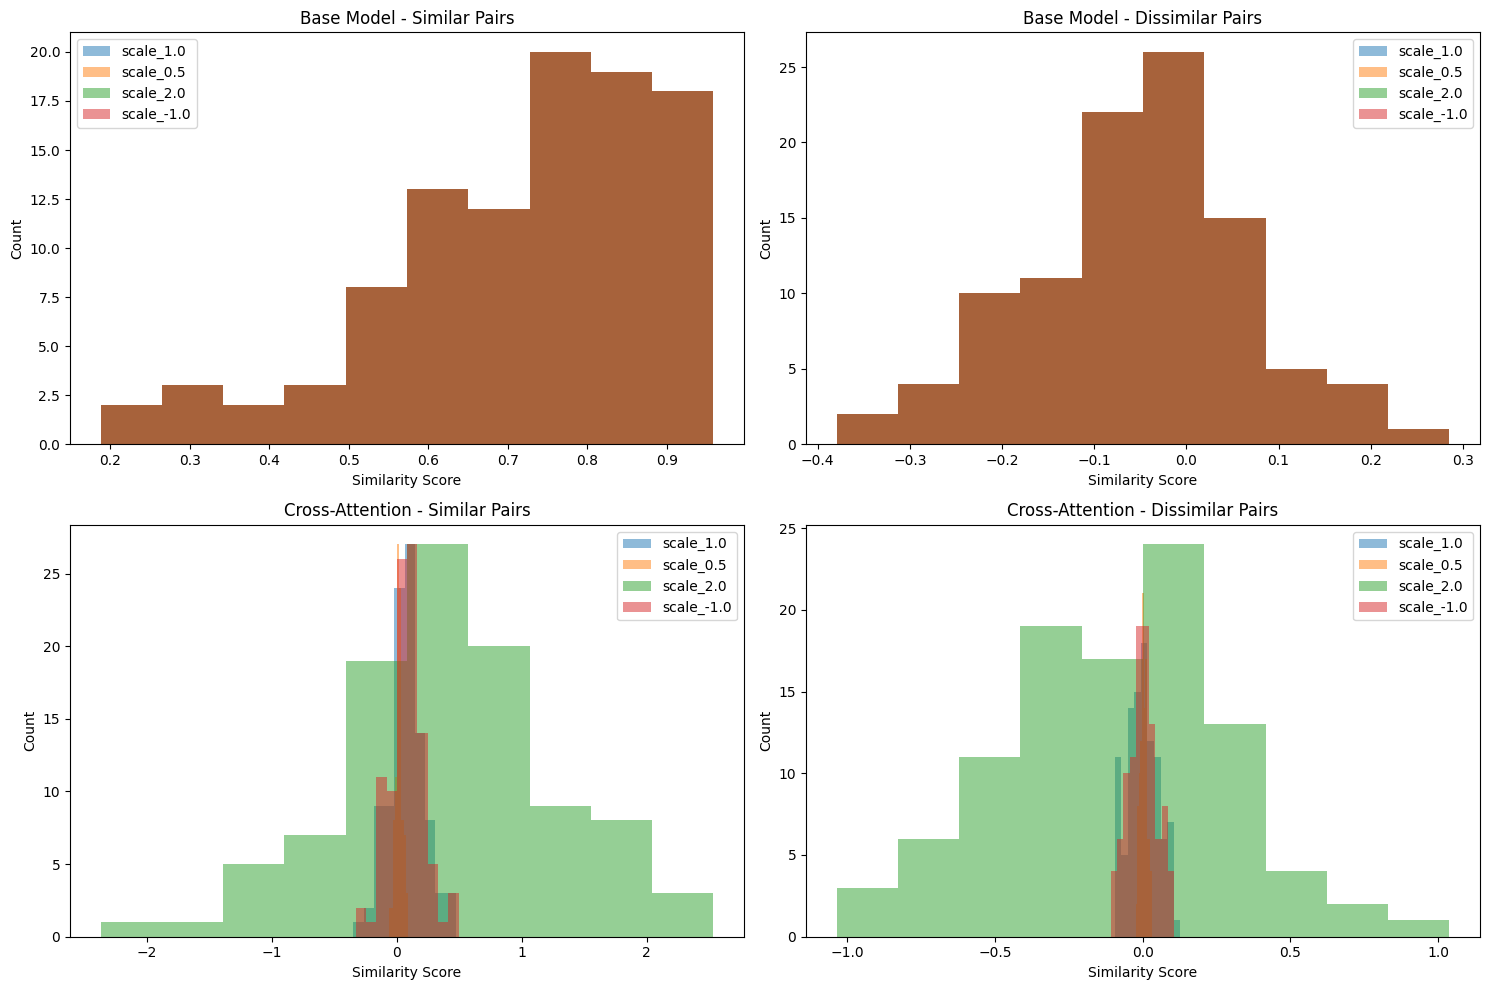

In [6]:

# Run the comparison
results = compare_models_similarity()

# Visualize the results with matplotlib
import matplotlib.pyplot as plt

def plot_similarity_distributions(results):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    for idx, (model_name, model_results) in enumerate([
        ('Base Model', results['base_model']),
        ('Cross-Attention', results['cross_attention'])
    ]):
        for scale, similarities in model_results['similar'].items():
            axes[idx, 0].hist(similarities, alpha=0.5, label=scale)
        axes[idx, 0].set_title(f'{model_name} - Similar Pairs')
        axes[idx, 0].set_xlabel('Similarity Score')
        axes[idx, 0].set_ylabel('Count')
        axes[idx, 0].legend()
        
        for scale, similarities in model_results['dissimilar'].items():
            axes[idx, 1].hist(similarities, alpha=0.5, label=scale)
        axes[idx, 1].set_title(f'{model_name} - Dissimilar Pairs')
        axes[idx, 1].set_xlabel('Similarity Score')
        axes[idx, 1].set_ylabel('Count')
        axes[idx, 1].legend()
    
    plt.tight_layout()
    plt.show()

plot_similarity_distributions(results)